In [1]:
from fbprophet import Prophet
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot
import pickle
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot
from fbprophet.plot import plot_plotly as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datos = pd.read_csv(r'EUR_USD_H1.csv')
print(datos.head)
print(f'El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

<bound method NDFrame.head of                    time  open_bid  high_bid  low_bid  close_bid  open_ask  \
0      2015-01-28 02 AM   1.13343   1.13398  1.13299    1.13338   1.13358   
1      2015-01-28 03 AM   1.13335   1.13429  1.13335    1.13397   1.13352   
2      2015-01-28 04 AM   1.13399   1.13413  1.13317    1.13362   1.13414   
3      2015-01-28 05 AM   1.13358   1.13632  1.13329    1.13547   1.13373   
4      2015-01-28 06 AM   1.13544   1.13815  1.13524    1.13693   1.13561   
...                 ...       ...       ...      ...        ...       ...   
49995  2023-02-09 09 PM   1.07328   1.07380  1.07323    1.07380   1.07342   
49996  2023-02-09 10 PM   1.07345   1.07408  1.07345    1.07391   1.07421   
49997  2023-02-09 11 PM   1.07392   1.07412  1.07373    1.07384   1.07434   
49998        2023-02-10   1.07385   1.07386  1.07248    1.07341   1.07402   
49999  2023-02-10 01 AM   1.07340   1.07349  1.07304    1.07339   1.07355   

       high_ask  low_ask  close_ask  
0      

In [3]:
df = datos[['open_bid', 'time']]
df.head()

,open_bid,time
0,1.13343,2015-01-28 02 AM
1,1.13335,2015-01-28 03 AM
2,1.13399,2015-01-28 04 AM
3,1.13358,2015-01-28 05 AM
4,1.13544,2015-01-28 06 AM


In [4]:
# Cambio de columna a datetime
df['time'] = pd.to_datetime(df['time'])
df.index = df.time
df_ARIMA = df.drop(['time'], axis = 1)


C:\Users\mpire\AppData\Local\Temp\ipykernel_13608\418822103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


In [5]:
# Resample del DataFrame , calculando open_bid promedio por día. 
exchange_rate_1 = df_ARIMA.resample('D').agg({'open_bid':'mean'})
exchange_rate_1

,open_bid
time,
2015-01-28,1.133460
2015-01-29,1.130125
2015-01-30,1.131697
2015-01-31,NaN
2015-02-01,1.130895
...,...
2023-02-06,1.076015
2023-02-07,1.072053
2023-02-08,1.073121


In [6]:
# Para saber si existen valores nulos
exchange_rate_1.isnull().sum()

open_bid    429
dtype: int64

In [7]:
# Eliminar valores nulos 
exchange_rate = exchange_rate_1.dropna()

In [8]:
df2 = exchange_rate.reset_index()

In [9]:
df2.head()

,time,open_bid
0,2015-01-28,1.133460
1,2015-01-29,1.130125
2,2015-01-30,1.131697
3,2015-02-01,1.130895
4,2015-02-02,1.132493


## Distribución de los datos 

<AxesSubplot:>

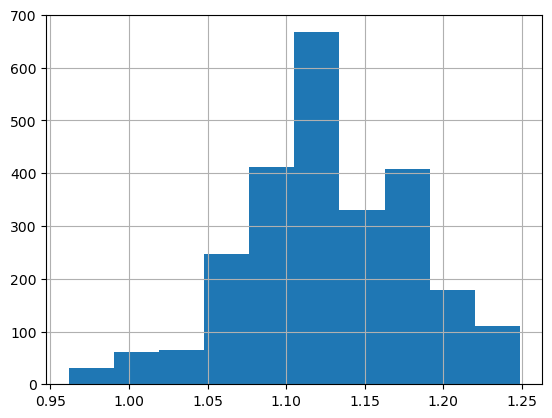

In [10]:
df2.open_bid.hist()

In [11]:
import plotly.express as px

In [12]:
fig = px.line(df2, x = df2.time, y = df2.open_bid, template = "plotly_dark",
            title = 'Variación de precio de apertura entre EUR y USD')
fig.show()

In [13]:
#Usaremos el 70% de los datos para train y el restante para test. 

training_data, testing_data = train_test_split(df2, test_size=0.3, random_state=42, shuffle=False)

#particion_datos = int(len(exchange_rate)*0.7)

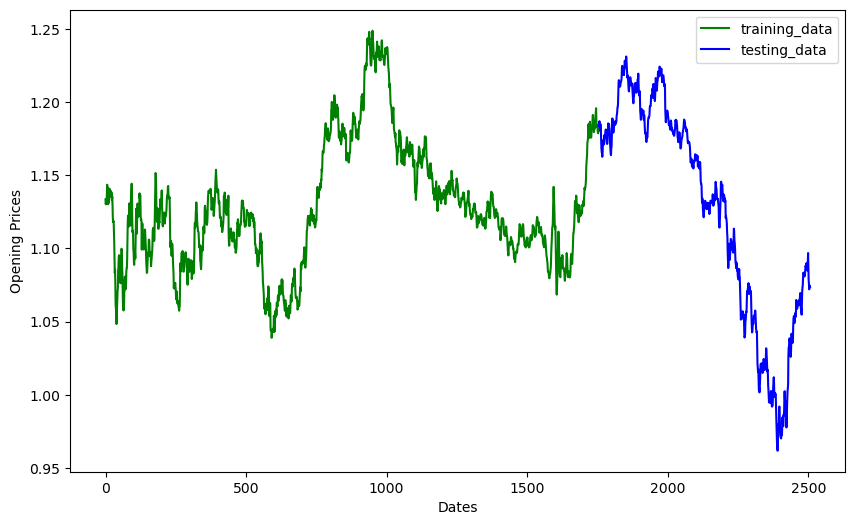

In [14]:
# Para ver gráficamente los datos de train y test

plt.figure(figsize=(10,6))
plt.grid=(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(training_data['open_bid'], 'green', label = 'training_data')
plt.plot(testing_data['open_bid'], 'blue', label = 'testing_data')
plt.legend()

In [15]:
testing_data

,time,open_bid
1754,2020-09-11,1.183865
1755,2020-09-13,1.183790
1756,2020-09-14,1.185861
1757,2020-09-15,1.186879
1758,2020-09-16,1.183972
...,...,...
2502,2023-02-06,1.076015
2503,2023-02-07,1.072053
2504,2023-02-08,1.073121
2505,2023-02-09,1.074574


In [16]:
training_data.rename(columns={'time': 'ds', 'open_bid': 'y'}, inplace=True)
train_data = training_data.sample(frac=0.8, random_state=10)
validation_data = training_data.drop(train_data.index)

print(f'training data size : {train_data.shape}')
print(f'validation data size : {validation_data.shape}')

train_data = train_data.reset_index()
validation_data = validation_data.reset_index()

training data size : (1403, 2)
validation data size : (351, 2)


In [17]:
training_data

,ds,y
0,2015-01-28,1.133460
1,2015-01-29,1.130125
2,2015-01-30,1.131697
3,2015-02-01,1.130895
4,2015-02-02,1.132493
...,...,...
1749,2020-09-06,1.184007
1750,2020-09-07,1.182413
1751,2020-09-08,1.179552
1752,2020-09-09,1.178632


In [18]:
model_exchange = Prophet(daily_seasonality=True)
model_exchange.fit(training_data)

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [19]:
# Guardar el modelo
with open('exchange.pkl', 'wb') as f:
    pickle.dump(model_exchange, f)

In [20]:
prediction = model_exchange.predict(pd.DataFrame({'ds':validation_data['ds']}))
y_actual = validation_data['y']
y_predicted = prediction['yhat']
#y_predicted = y_predicted.astype(int)
mean_absolute_error(y_actual, y_predicted)

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.009895208933272543

In [21]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-28,1.130448,1.118734,1.151346,1.130448,1.130448,0.004583,0.004583,0.004583,0.00802,...,0.000068,0.000068,0.000068,-0.003504,-0.003504,-0.003504,0.0,0.0,0.0,1.135031
1,2015-01-30,1.129663,1.118377,1.150752,1.129663,1.129663,0.004539,0.004539,0.004539,0.00802,...,0.000214,0.000214,0.000214,-0.003695,-0.003695,-0.003695,0.0,0.0,0.0,1.134201
2,2015-02-02,1.128484,1.116299,1.147804,1.128484,1.128484,0.004034,0.004034,0.004034,0.00802,...,0.000184,0.000184,0.000184,-0.004170,-0.004170,-0.004170,0.0,0.0,0.0,1.132518
3,2015-02-03,1.128092,1.116052,1.147037,1.128092,1.128092,0.003804,0.003804,0.003804,0.00802,...,0.000166,0.000166,0.000166,-0.004382,-0.004382,-0.004382,0.0,0.0,0.0,1.131896
4,2015-02-12,1.124557,1.109893,1.141392,1.124557,1.124557,0.000765,0.000765,0.000765,0.00802,...,0.000412,0.000412,0.000412,-0.007667,-0.007667,-0.007667,0.0,0.0,0.0,1.125321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2020-08-16,1.129537,1.147852,1.178891,1.129537,1.129537,0.033602,0.033602,0.033602,0.00802,...,-0.000042,-0.000042,-0.000042,0.025625,0.025625,0.025625,0.0,0.0,0.0,1.163140
347,2020-08-18,1.129803,1.150073,1.180865,1.129803,1.129803,0.034750,0.034750,0.034750,0.00802,...,0.000166,0.000166,0.000166,0.026564,0.026564,0.026564,0.0,0.0,0.0,1.164553
348,2020-08-30,1.131393,1.153432,1.186312,1.131393,1.131393,0.039445,0.039445,0.039445,0.00802,...,-0.000042,-0.000042,-0.000042,0.031468,0.031468,0.031468,0.0,0.0,0.0,1.170839
349,2020-09-01,1.131658,1.155328,1.187760,1.131658,1.131658,0.039977,0.039977,0.039977,0.00802,...,0.000166,0.000166,0.000166,0.031791,0.031791,0.031791,0.0,0.0,0.0,1.171635


In [22]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_actual, name="actual targets"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_predicted, name="predicted targets"),
    secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

In [23]:
test_prediction = model_exchange.predict(pd.DataFrame({'ds':testing_data['time']}))

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [24]:
test_prediction


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-09-11,1.132984,1.155141,1.188422,1.132984,1.132984,0.038643,0.038643,0.038643,0.00802,...,0.000214,0.000214,0.000214,0.030410,0.030410,0.030410,0.0,0.0,0.0,1.171627
1,2020-09-13,1.133249,1.155004,1.187826,1.133249,1.133249,0.037653,0.037653,0.037653,0.00802,...,-0.000042,-0.000042,-0.000042,0.029676,0.029676,0.029676,0.0,0.0,0.0,1.170902
2,2020-09-14,1.133382,1.154267,1.188381,1.133382,1.133382,0.037483,0.037483,0.037483,0.00802,...,0.000184,0.000184,0.000184,0.029279,0.029279,0.029279,0.0,0.0,0.0,1.170864
3,2020-09-15,1.133514,1.154375,1.188154,1.133514,1.133514,0.037054,0.037054,0.037054,0.00802,...,0.000166,0.000166,0.000166,0.028868,0.028868,0.028868,0.0,0.0,0.0,1.170568
4,2020-09-16,1.133647,1.154463,1.186564,1.133647,1.133647,0.036535,0.036535,0.036535,0.00802,...,0.000068,0.000068,0.000068,0.028447,0.028447,0.028447,0.0,0.0,0.0,1.170182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2023-02-06,1.249372,0.057893,2.425858,0.054521,2.426207,0.003016,0.003016,0.003016,0.00802,...,0.000184,0.000184,0.000184,-0.005188,-0.005188,-0.005188,0.0,0.0,0.0,1.252389
749,2023-02-07,1.249505,0.059806,2.416373,0.052700,2.427201,0.002669,0.002669,0.002669,0.00802,...,0.000166,0.000166,0.000166,-0.005518,-0.005518,-0.005518,0.0,0.0,0.0,1.252173
750,2023-02-08,1.249637,0.061805,2.430330,0.050879,2.428179,0.002208,0.002208,0.002208,0.00802,...,0.000068,0.000068,0.000068,-0.005880,-0.005880,-0.005880,0.0,0.0,0.0,1.251845
751,2023-02-09,1.249770,0.054816,2.439849,0.049059,2.429156,0.002157,0.002157,0.002157,0.00802,...,0.000412,0.000412,0.000412,-0.006275,-0.006275,-0.006275,0.0,0.0,0.0,1.251927


In [25]:
test_prediction.yhat

0      1.171627
1      1.170902
2      1.170864
3      1.170568
4      1.170182
         ...   
748    1.252389
749    1.252173
750    1.251845
751    1.251927
752    1.251432
Name: yhat, Length: 753, dtype: float64

In [26]:
testing_data_2 = testing_data.reset_index(drop=True)

In [27]:
testing_data_2['pred'] = test_prediction.yhat
testing_data_2

,time,open_bid,pred
0,2020-09-11,1.183865,1.171627
1,2020-09-13,1.183790,1.170902
2,2020-09-14,1.185861,1.170864
3,2020-09-15,1.186879,1.170568
4,2020-09-16,1.183972,1.170182
...,...,...,...
748,2023-02-06,1.076015,1.252389
749,2023-02-07,1.072053,1.252173
750,2023-02-08,1.073121,1.251845
751,2023-02-09,1.074574,1.251927


In [28]:
testing_data_2.to_csv('predicciones_monedas.csv', index=False)